In [1]:
# imports
!pip install requests_cache --upgrade
!pip install PyPortfolioOpt --upgrade
import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import requests_cache
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt import plotting

In [2]:
# Pull stock data from yahoo finance
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite')
session.headers = {     'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',     'Accept': 'application/json;charset=utf-8'     }

def get_data_for_multiple_stocks(tickers,start_date,end_date):
    #define helper function here
    #
    
    
    stocks = dict()
    stocks_adj_close = pd.DataFrame()
    # loop through all the tickers
    for ticker in tickers:
        
        # get the data for the specific ticker
        s = DataReader(ticker, 'yahoo', start_date, end_date, session=session)
      
        s.insert(0, "Ticker", ticker)  #insert ticker column so you can reference better later
        
        s['Prev Close'] = s['Adj Close'].shift(1)
        s['log_return'] = np.log(s['Adj Close']/s['Prev Close'])
        s['perc_return'] = (s['Adj Close']/s['Prev Close']) - 1
        # add it to the dictionary
        stocks[ticker] = s
        stocks_adj_close[ticker] = s['Adj Close']
    # return the dictionary
    return stocks, stocks_adj_close

In [3]:
# Top 30 stocks in best portfolio
tickers = ['NVDA','QCOM', 'NXPI', 'MU', 'MRVL', 'AMD', 'MCHP', 'AVGO', 'XLNX', 'LRCX'
    ,'ON', 'INTC', 'TXN', 'ENPH', 'AMAT', 'CRUS', 'JBL', 'ADI', 'OLED', 'TSM'
    , 'IIVI', 'DIOD', 'AEIS', 'MTSI', 'TTMI', 'FLEX', 'MXL', 'SMTC', 'SYNA', 'AOSL']

#we only need the adjusted close data to work with this library
df =  get_data_for_multiple_stocks(tickers,start_date='2019-01-01',end_date= '2020-12-31')[1]
print(df)

                  NVDA        QCOM        NXPI  ...       SMTC       SYNA       AOSL
Date                                            ...                                 
2019-01-02   33.841221   53.195831   72.566757  ...  46.150002  37.540001  10.540000
2019-01-03   31.796637   51.620346   69.607224  ...  43.110001  35.020000   9.940000
2019-01-04   33.833778   52.454422   72.972984  ...  45.810001  36.009998  10.440000
2019-01-07   35.624958   52.306145   73.514603  ...  47.490002  36.259998  10.360000
2019-01-08   34.738052   51.852032   73.930473  ...  47.869999  37.970001  10.580000
...                ...         ...         ...  ...        ...        ...        ...
2020-12-24  129.839996  146.649475  156.010971  ...  71.720001  86.150002  23.430000
2020-12-28  128.903214  145.614594  156.843933  ...  71.910004  92.129997  23.969999
2020-12-29  129.335373  146.353821  154.602875  ...  70.529999  90.639999  22.840000
2020-12-30  131.358871  147.792786  158.053711  ...  71.989998  9

In [4]:
#Checking if any NaN values in the data
nullin_df = pd.DataFrame(df,columns=tickers)
print(nullin_df.isnull().sum())

NVDA    0
QCOM    0
NXPI    0
MU      0
MRVL    0
AMD     0
MCHP    0
AVGO    0
XLNX    0
LRCX    0
ON      0
INTC    0
TXN     0
ENPH    0
AMAT    0
CRUS    0
JBL     0
ADI     0
OLED    0
TSM     0
IIVI    0
DIOD    0
AEIS    0
MTSI    0
TTMI    0
FLEX    0
MXL     0
SMTC    0
SYNA    0
AOSL    0
dtype: int64


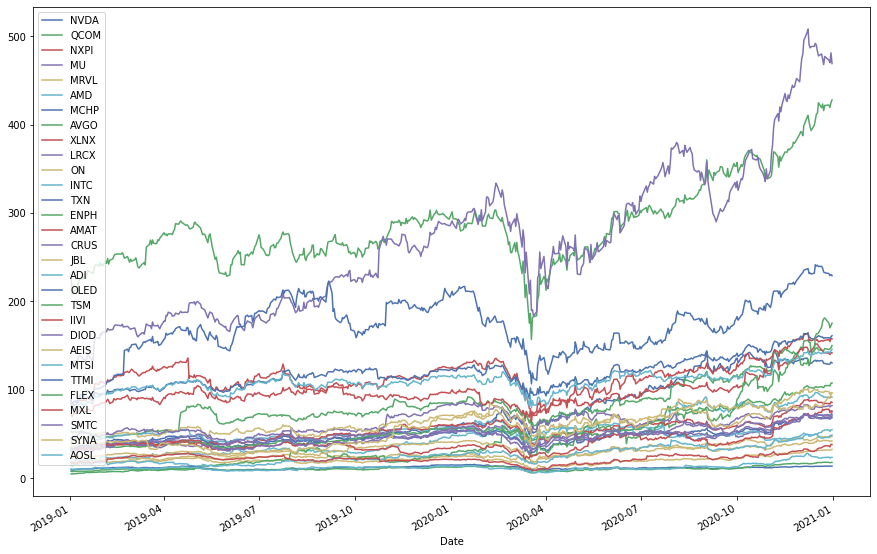

In [5]:
df.plot(figsize=(15,10));

We know from the previous assignment that since equal weight is applied to all returns across the sample period, mean historical returns may not be able to accurately account for the diminishing predictability of older data, we want to determine if different methods could return better performance.

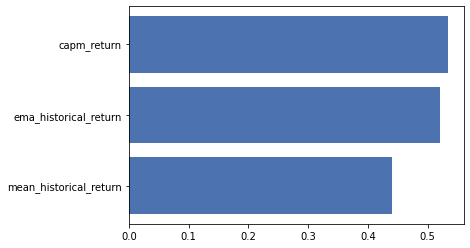

In [6]:
past_df, future_df = df.iloc[:-253], df.iloc[-253:]

future_rets = expected_returns.mean_historical_return(future_df)
mean_abs_errors = []
return_methods = [
    "mean_historical_return",
    "ema_historical_return",
    "capm_return",
    ]

for method in return_methods:
    mu = expected_returns.return_model(past_df, method=method)
    mean_abs_errors.append(np.sum(np.abs(mu - future_rets)) / len(mu))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, return_methods)
plt.show()

In [7]:
return_methods_arr = np.array(return_methods)
mean_abs_error_arr = np.array(mean_abs_errors)
return_error_df = pd.DataFrame({'return_methods':return_methods_arr, 'mean_abs_errors':mean_abs_error_arr})
return_error_df

,return_methods,mean_abs_errors
0,mean_historical_return,0.440192
1,ema_historical_return,0.520662
2,capm_return,0.533879


We observe that the capm_return is marginally better than the other two methods. We also need to note that while a higher absolute deviation value indicates higher gains for realised annual returns; it also indicates to higher losses.

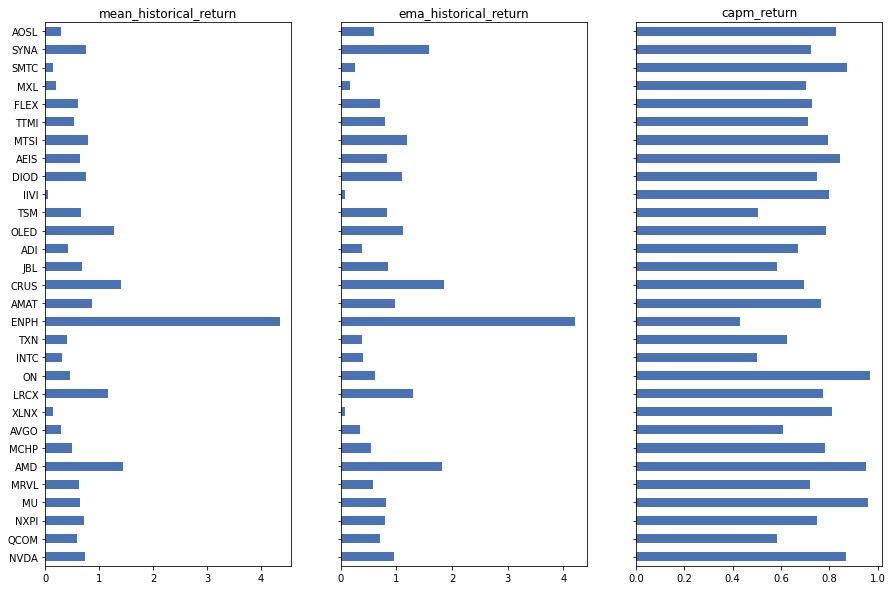

In [8]:
fig, axs = plt.subplots( 1, len(return_methods),sharey=True, figsize=(15,10))

for i, method in enumerate(return_methods):
    mu = expected_returns.return_model(past_df, method=method)
    axs[i].set_title(method)
    mu.plot.barh(ax=axs[i])

Furthermore we can observe that CAPM returns to be slightly more stable than the default mean historical return

Now we will optimize our mutual funds holding using the semi-variance objective function as outlined in qn 1. We minimise the portfolio semivariance (downside volatility) to try and achieve a return constraint of 80%.

In [9]:
mu = expected_returns.capm_return(df, risk_free_rate=0.01) #rf = 1% as per instructions

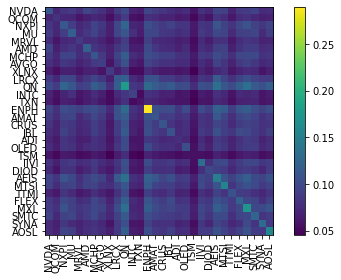

In [10]:
semicov = risk_models.semicovariance(df, benchmark=0)
plotting.plot_covariance(semicov);

Gamma = 0.9 Sharpe ratio

In [11]:
ef = EfficientFrontier(mu, semicov, weight_bounds=(0, 0.25)) #weight constraints must be <= 25%
ef.add_objective(objective_functions.L2_reg, gamma=0.9)  # gamme is the tuning parameter, we determine that gamma = 0.3 is optimal
ef.efficient_return(0.8) #target return of 80%

weights = ef.clean_weights()
weights

OrderedDict([('NVDA', 0.00436),
             ('QCOM', 0.0),
             ('NXPI', 0.03938),
             ('MU', 0.05114),
             ('MRVL', 0.0),
             ('AMD', 0.0),
             ('MCHP', 0.06677),
             ('AVGO', 0.0),
             ('XLNX', 0.0),
             ('LRCX', 0.09055),
             ('ON', 0.21287),
             ('INTC', 0.0),
             ('TXN', 0.0),
             ('ENPH', 0.09268),
             ('AMAT', 0.04917),
             ('CRUS', 0.0),
             ('JBL', 0.0),
             ('ADI', 0.0),
             ('OLED', 0.0),
             ('TSM', 0.0),
             ('IIVI', 0.0),
             ('DIOD', 0.0),
             ('AEIS', 0.12309),
             ('MTSI', 0.03778),
             ('TTMI', 0.0),
             ('FLEX', 0.02425),
             ('MXL', 0.12695),
             ('SMTC', 0.07298),
             ('SYNA', 0.0),
             ('AOSL', 0.00803)])

In [12]:
ef.portfolio_performance(verbose=True);

Expected annual return: 80.0%
Annual volatility: 34.3%
Sharpe Ratio: 2.27


gamma = 0.1 Sharpe ratio

In [13]:
ef = EfficientFrontier(mu, semicov, weight_bounds=(0, 0.25)) #weight constraints must be <= 25%
ef.add_objective(objective_functions.L2_reg, gamma=0.1)  # gamme is the tuning parameter, we determine that gamma = 0.3 is optimal
ef.efficient_return(0.8) #target return of 80%

weights = ef.clean_weights()
weights

OrderedDict([('NVDA', 0.02139),
             ('QCOM', 0.0),
             ('NXPI', 0.01669),
             ('MU', 0.07371),
             ('MRVL', 0.0),
             ('AMD', 0.0),
             ('MCHP', 0.0919),
             ('AVGO', 0.0),
             ('XLNX', 0.0),
             ('LRCX', 0.12574),
             ('ON', 0.22137),
             ('INTC', 0.0),
             ('TXN', 0.0),
             ('ENPH', 0.04647),
             ('AMAT', 0.04006),
             ('CRUS', 0.0),
             ('JBL', 0.0),
             ('ADI', 0.0),
             ('OLED', 0.0),
             ('TSM', 0.0),
             ('IIVI', 0.0),
             ('DIOD', 0.0),
             ('AEIS', 0.1139),
             ('MTSI', 0.023),
             ('TTMI', 0.0),
             ('FLEX', 0.0),
             ('MXL', 0.12363),
             ('SMTC', 0.10216),
             ('SYNA', 0.0),
             ('AOSL', 0.0)])

In [14]:
ef.portfolio_performance(verbose=True);

Expected annual return: 80.0%
Annual volatility: 34.0%
Sharpe Ratio: 2.29


Plotting the uncontrained efficient frontier

In [15]:
from pypfopt import CLA, plotting

cla = CLA(mu, semicov)
cla.max_sharpe()
cla.portfolio_performance(verbose=True);

Expected annual return: 66.9%
Annual volatility: 27.4%
Sharpe Ratio: 2.37


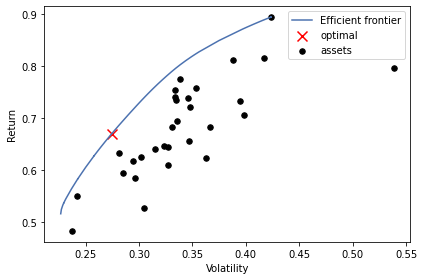

In [16]:

ax = plotting.plot_efficient_frontier(cla, showfig=False)